In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import regex as re
import plotly.graph_objects as go
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from joblib import dump, load
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/IS353/Dataset

/content/drive/MyDrive/IS353/Dataset


In [4]:
!ls

01.sinhvien.xlsx	   08.XLHV.xlsx       sinhvien_dtb_hocky.xlsx
02.diem.xlsx		   10.diemrl.xlsx     sinhvien_dtb_toankhoa.xlsx
03.sinhvien_chungchi.xlsx  12.baoluu.xlsx     test_data.csv
04.xeploaiav.xlsx	   14.totnghiep.xlsx  train_data.csv
05.ThiSinh.xlsx		   diemrl.xlsx	      uit_hocphi_miengiam.xlsx
06.giayxacnhan.xlsx	   diem_Thu.xlsx      ultimate_merged_df.csv


# Preprocessing

In [5]:
def normalize_string(s):
  try:
    if s.endswith('\'') & s.startswith(' \''):
      return s[2:-1]
    return s
  except:
    return s

def replace_null(x):
  try:
    if "NULL" in x:
        return np.nan
    else:
        return x
  except:
    return x

uniChars = "àáảãạâầấẩẫậăằắẳẵặèéẻẽẹêềếểễệđìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶÈÉẺẼẸÊỀẾỂỄỆĐÌÍỈĨỊÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢÙÚỦŨỤƯỪỨỬỮỰỲÝỶỸỴÂĂĐÔƠƯ"
unsignChars = "aaaaaaaaaaaaaaaaaeeeeeeeeeeediiiiiooooooooooooooooouuuuuuuuuuuyyyyyAAAAAAAAAAAAAAAAAEEEEEEEEEEEDIIIOOOOOOOOOOOOOOOOOOOUUUUUUUUUUUYYYYYAADOOU"

def loaddicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

dicchar = loaddicchar()

def covert_unicode(txt):
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], txt)

## Sinh viên

In [6]:
# Đọc file
df_student = pd.read_excel('01.sinhvien.xlsx')

# Lọc các cột không cần thiết
df_student = df_student.filter(regex='^(?!_([1-9]|[1-4][0-9]|5[0-6]))')
df_student = df_student.drop(columns=['Column1'])

# Loại bỏ khoảng trắng ở đầu và cuối của các giá trị trong cột mssv
df_student['mssv']= df_student['mssv'].str.strip()

# Loại bỏ các dòng có toàn bộ giá trị là NaN
df_student = df_student.dropna(how='all')

# Loại bỏ các dòng có toàn bộ giá trị là NaN
df_student.columns = df_student.columns.str.lstrip()

# Loại bỏ các cột trùng lặp
df_student=df_student.T.drop_duplicates().T

# Chuẩn hóa chuỗi (normalize_string) cho các cột kiểu object
object_columns = df_student.select_dtypes(include=['object']).columns.tolist()
df_student[object_columns]=df_student.select_dtypes(include=['object']).applymap(normalize_string)

object_columns = df_student.select_dtypes(include=['object']).columns.tolist()
df_student[object_columns]=df_student.select_dtypes(include=['object']).applymap(replace_null)

<ipython-input-6-4edc2130b4ea>:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_student[object_columns]=df_student.select_dtypes(include=['object']).applymap(normalize_string)
<ipython-input-6-4edc2130b4ea>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_student[object_columns]=df_student.select_dtypes(include=['object']).applymap(replace_null)


In [7]:
# Định nghĩa ánh xạ
khoahoc_map = {
    '8': '2013',
    '9': '2014',
    '10': '2015',
    '11': '2016',
    '12': '2017',
    '13': '2018',
    '14': '2019'
}

# Đổi kiểu dữ liệu
df_student['khoahoc'] = df_student['khoahoc'].astype(str).str.replace('.0', '', regex=False)

# Ánh xạ với Khoahoc_map
df_student['namkhoahoc'] = df_student['khoahoc'].map(khoahoc_map)
df_student

,id,mssv,namsinh,gioitinh,noisinh,lopsh,khoa,hedt,khoahoc,chuyennganh2,tinhtrang,diachi_tinhtp,namkhoahoc
0,1.0,BE375BAAXPvAibaEXe9JDlHA4z2GHJ3/PVStCxR2,1995.0,1.0,TP. Hồ Chí Minh,KTPM0001,CNPM,CQUI,8,D480103,3.0,Thành phố Hồ Chí Minh,2013
1,2.0,2420ED57XPvAibaEXe/Lh6v1XxTKJa6JLFRUPkLM,1995.0,1.0,Đồng Tháp,HTTT0001,HTTT,CTTT,8,D480104,3.0,Huyện Hóc Môn,2013
2,3.0,83B76C01XPvAibaEXe/lOccskaOiO2K46r7t4qnt,1994.0,1.0,Hà Nam Ninh,KHMT2013,KHMT,CQUI,8,D480101,5.0,Tỉnh Hà Nam,2013
3,4.0,91F785ABXPvAibaEXe/lOccskaOiO5y4GbVvuRQu,1995.0,1.0,TP. Hồ Chí Minh,HTTT0001,HTTT,CTTT,8,D480104,3.0,Thành phố Hồ Chí Minh,2013
4,5.0,007C275DXPvAibaEXe+TFgEDwYNnveOOmOYeYzF6,1995.0,1.0,Thành phố Hồ Chí Minh,MMTT0001,MMT&TT,CQUI,8,D480201,8.0,Thành phố Hồ Chí Minh,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8311,19283.0,7D7633B0XPvAibaEXe95IhrkYSGfcCQVGm4nFGyt,2000.0,1.0,An Giang,MMCL2019.2,MMT&TT,CLC,14,7480102,2.0,Tỉnh An Giang,2019
8312,19284.0,AB431338XPvAibaEXe8xMCTZ03/BexWzDCyWVsT3,2001.0,1.0,Bình Thuận,KHMT2019,KHMT,CQUI,14,D480101,1.0,Tỉnh Bình Thuận,2019
8313,19285.0,75AD7B4AXPvAibaEXe8xMCTZ03/BewoGrWSt0ZXM,2001.0,1.0,Lâm Đồng,KHMT2019,KHMT,CQUI,14,D480101,1.0,Tỉnh Lâm Đồng,2019
8314,19345.0,CB263C18XPvAibaEXe8xMCTZ03/Be8yk40QWdPiR,2000.0,1.0,Bến Tre,CNTT2019,KTTT,CQUI,14,D480201,1.0,Tỉnh Bến Tre,2019


## Xử lý học vụ

In [8]:
df_XLHV = pd.read_excel('08.XLHV.xlsx')
df_XLHV.columns = df_XLHV.columns.str.lstrip()

for i in range(len(df_XLHV)):
    # Nếu giá trị ở cột "Column1" không rỗng và cột "hocky" là NaN
    if df_XLHV.loc[i, "Column1"] and pd.isna(df_XLHV.loc[i, "hocky"]):
        # Dịch chuyển các giá trị từ cột "hocky" trở đi lên một hàng
        df_XLHV.loc[i, "hocky":] = df_XLHV.loc[i, "hocky":].shift(-1)

df_XLHV = df_XLHV.drop("Column1", axis=1)
df_XLHV = df_XLHV.dropna(how='all')
df_XLHV["namhoc"] = df_XLHV["namhoc"].astype(float)

# Chuẩn hóa chuỗi (normalize_string) cho các cột kiểu object
object_columns = df_XLHV.select_dtypes(include=['object']).columns.tolist()
df_XLHV[object_columns]=df_XLHV.select_dtypes(include=['object']).applymap(normalize_string)

<ipython-input-8-82d6ddb7cce6>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2017' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_XLHV.loc[i, "hocky":] = df_XLHV.loc[i, "hocky":].shift(-1)
<ipython-input-8-82d6ddb7cce6>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value ' 2017-10-26);' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df_XLHV.loc[i, "hocky":] = df_XLHV.loc[i, "hocky":].shift(-1)
<ipython-input-8-82d6ddb7cce6>:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_XLHV[object_columns]=df_XLHV.select_dtypes(include=['object']).applymap(normalize_string)


In [9]:
df_XLHV['lydo'] = df_XLHV['lydo'].str.lstrip().astype('string')
df_XLHV['lydo'] = df_XLHV['lydo'].apply(lambda x: x.replace(':\\n-', '').replace('\\n-', ''))
df_XLHV['lydo'] = df_XLHV['lydo'].apply(lambda x: x.replace(':', ''))
df_XLHV['lydo'] = df_XLHV['lydo'].apply(lambda x: x.replace('trể', 'trễ'))

df_XLHV['lydo'] = df_XLHV['lydo'].replace(r'\s+', ' ', regex=True)
df_XLHV['lydo'] = df_XLHV['lydo'].str.replace("^'", '', regex=True)

df_XLHV['lydo'] = df_XLHV['lydo'].str.replace('Bị cảnh cáo vì đtb 2 học kỳ tiếp < 4', 'Bị cảnh cáo vì ĐTB 2 học kỳ liên tiếp < 4', regex=True)
df_XLHV['lydo'] = df_XLHV['lydo'].str.replace('Buộc thôi học', 'BTH', regex=True)
df_XLHV['lydo'] = df_XLHV['lydo'].str.capitalize()
df_XLHV['lydo'] = df_XLHV['lydo'].str.replace('điểm trung bình', 'đtb', regex=True)
df_XLHV['lydo'] = df_XLHV['lydo'].str.replace('báo', 'cáo', regex=True)
df_XLHV['lydo'] = df_XLHV['lydo'].str.replace('ĐTB', 'đtb', regex=True)
df_XLHV['lydo'] = df_XLHV['lydo'].str.replace('bthđtb', 'bth vì đtb', regex=True)
df_XLHV['lydo'] = df_XLHV['lydo'].str.replace('vì vì', 'vì', regex=True)

In [10]:
# Kiểm tra và chuẩn hóa chuỗi theo các điều kiện đã xác định
def check_string(string):
  if ('đóng học phí trễ' not in string) and (('Bị cảnh cáo' in string) and ('đtb học kỳ' in string)):
    return 'Bị cảnh cáo vì ĐTB học kỳ'
  elif ('Bị buộc thôi học vì đtb' in string) or (('Bth' in string) and ('đtb' in string)):
    return 'Buộc thôi học vì ĐTB học kỳ'
  elif ('đóng học phí trễ' in string) and (('Bị cảnh cáo' in string) and ('đtb học kỳ' in string)):
    return 'Bị cảnh cáo vì ĐTB và trễ học phí'
  elif 'quá hạn đào tạo' in string:
    return 'Quá hạn đào tạo'
  elif 'xem xét hạ mức' in string:
    return 'Được xem xét hạ mức'
  elif ('bảo lưu' in string and 'không nhập học lại' in string) or ('Bảo lưu nhưng không nhập học lại' in string) or ('Bảo lưu không nhập học lại' in string):
    return 'Buộc thôi học vì bảo lưu không nhập học lại'
  elif ('lần thứ 3 liên tiếp' in string) or ('3 lần liên tiếp' in string) or ('3 hk liên tiếp' in string):
    return 'Buộc thôi học vì cảnh báo 3 lần liên tiếp'
  elif ('chuyển tự do' in string) or ('chuyển từ xa' in string) or ('sang hệ từ xa' in string):
    return 'Xem xét chuyển qua hệ đào tạo không chính quy'
  elif ('đóng học phí trễ' in string) or 'đóng học phí trễ' in string:
    return 'Bị cảnh cáo vì đóng học phí trễ'
  elif 'Bị cảnh cáo vì đtb 2 học kỳ tiếp < 4' in string:
    return 'Bị cảnh cáo vì ĐTB 2 học kỳ liên tiếp < 4'
  elif 'Bị cảnh cáo vì đtb 2 học kỳ liên tiếp < 4' in string:
    return 'Bị cảnh cáo vì ĐTB 2 học kỳ liên tiếp < 4'
  else:
    return string

df_XLHV['lydo'] = df_XLHV['lydo'].astype(str).apply(check_string)

In [11]:
df_XLHV.loc[df_XLHV['lydo'].str.contains('Buộc thôi học'), 'tinhtrang'] = 5
df_XLHV.loc[df_XLHV['lydo'].str.contains('Bị cảnh cáo'), 'tinhtrang'] = 2

In [12]:
# Merge dữ liệu từ `df_XLHV` và `df_student` dựa trên cột "mssv"
df_xlhv_sv = pd.merge(df_XLHV, df_student, on='mssv', how='left', suffixes=('_xlhv', '_student'))

df_xlhv_sv['namkhoahoc'] = df_xlhv_sv['namkhoahoc'].astype(float)
df_xlhv_sv['namhoc'] = df_xlhv_sv['namhoc'].astype(float)
df_xlhv_sv['hocky'] = df_xlhv_sv['hocky'].astype(float)

# Tổng số kỳ
df_xlhv_sv['hk'] = (df_xlhv_sv['namhoc'] - df_xlhv_sv['namkhoahoc']) * 2 + df_xlhv_sv['hocky']
df_xlhv_sv

,id_xlhv,mssv,tinhtrang_xlhv,lydo,hocky,namhoc,soqd,ngayqd,id_student,namsinh,...,noisinh,lopsh,khoa,hedt,khoahoc,chuyennganh2,tinhtrang_student,diachi_tinhtp,namkhoahoc,hk
0,7595.0,98247E19XPvAibaEXe93PEySAJOVkxsz+HIviyYJ,2.0,Bị cảnh cáo vì ĐTB học kỳ,2.0,2016.0,189/QĐ-ĐHCNTT,2017-04-18 00:00:00,8280.0,1995.0,...,Cần Thơ,HTTT0001,HTTT,CQUI,8,D52480104,5.0,Thành phố Cần Thơ,2013.0,8.0
1,7596.0,52B1CC2DXPvAibaEXe+kwIr/VXjl0w+FyuW1abQ7,2.0,Bị cảnh cáo vì ĐTB học kỳ,2.0,2016.0,189/QĐ-ĐHCNTT,2017-04-18 00:00:00,8514.0,1995.0,...,Đăk Lăk,HTTT2013,HTTT,CQUI,8,D480104,5.0,Huyện Krông Năng,2013.0,8.0
2,7597.0,5666EAF4XPvAibaEXe+Z7KfNHYLttJaLI+SH+DpO,2.0,Bị cảnh cáo vì ĐTB học kỳ,2.0,2016.0,189/QĐ-ĐHCNTT,2017-04-18 00:00:00,8747.0,1995.0,...,Quảng Ngãi,HTTT2013,HTTT,CQUI,8,D480104,5.0,Tỉnh Quảng Ngãi,2013.0,8.0
3,7598.0,682C32E0XPvAibaEXe/Bn5cQSu92WX0DcIKdud8D,2.0,Bị cảnh cáo vì ĐTB 2 học kỳ liên tiếp < 4,2.0,2016.0,189/QĐ-ĐHCNTT,2017-04-18 00:00:00,8795.0,1995.0,...,An Giang,HTTT2013,HTTT,CQUI,8,D480104,5.0,Tỉnh An Giang,2013.0,8.0
4,7599.0,7901D3A9XPvAibaEXe+6MN9FoW2mqYEmruXXBNsS,2.0,Bị cảnh cáo vì ĐTB học kỳ,2.0,2016.0,189/QĐ-ĐHCNTT,2017-04-18 00:00:00,8888.0,1995.0,...,Quảng Ngãi,HTTT0001,HTTT,CQUI,8,D480104,5.0,Tình Quảng Ngãi,2013.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3440,21278.0,9B23F85CXPvAibaEXe/QqI5At3DBgidRMGrBbipk,8.0,Xem xét chuyển qua hệ đào tạo không chính quy,2.0,2020.0,244/QĐ-ĐHCNTT,NaT,11285.0,1996.0,...,Bến Tre,KTPM0001,CNPM,CQUI,10,D480103,3.0,Tỉnh Bến Tre,2015.0,12.0
3441,21279.0,33B4B1F5XPvAibaEXe+4XPPXlKRz0EV4ZG7086cL,8.0,Xem xét chuyển qua hệ đào tạo không chính quy,2.0,2020.0,244/QĐ-ĐHCNTT,NaT,11490.0,1997.0,...,Bình Định,KTPM0001,CNPM,CQUI,10,D480103,8.0,Tỉnh Bình Định,2015.0,12.0
3442,21280.0,7ACF3993XPvAibaEXe9p78qxnH96y309RWXe+E33,8.0,Xem xét chuyển qua hệ đào tạo không chính quy,2.0,2020.0,244/QĐ-ĐHCNTT,NaT,11606.0,1997.0,...,Bình Định,KTPM0001,CNPM,CQUI,10,D480103,8.0,Tỉnh Bình Định,2015.0,12.0
3443,21281.0,7BEDC07CXPvAibaEXe9KWpGOh3zHl5qOD67ZCwQD,5.0,Xem xét chuyển qua hệ đào tạo không chính quy,2.0,2020.0,252/QĐ-ĐHCNTT,NaT,11315.0,1997.0,...,Hà Tĩnh,CNTT0001,KTTT,CQUI,10,D480201,5.0,Tỉnh Kon Tum,2015.0,12.0


## Cảnh báo học vụ

In [13]:
# Lọc dữ liệu từ `df_XLHV` chỉ bao gồm các trường hợp có "tinhtrang" là 2 (Bị cảnh cáo)
df_warning = df_XLHV[df_XLHV['tinhtrang'] == 2]

# Ghép thêm cột "namkhoahoc" từ `df_student` vào `df_warning` dựa trên cột "mssv"
df_warning = df_warning.merge(df_student[['mssv','namkhoahoc']], on='mssv')

# Tính giá trị "namhoc" của sinh viên dựa trên "namkhoahoc"
df_warning['namhoc'] = df_warning['namhoc'] - df_warning['namkhoahoc'].astype('int') + 1

# Tính "hk" (số kỳ học) bằng công thức: học kỳ hiện tại cộng với số kỳ đã học từ trước
df_warning['hk'] = df_warning['hocky'] + (df_warning['namhoc']-1)*2

# Xác định lần cảnh cáo (lanthu) bằng cách sắp xếp theo "mssv" và "hk",
df_warning['lanthu'] = df_warning.sort_values(['mssv','hk'], ascending=True).groupby('mssv').cumcount() + 1

df_warning.head(5)

,id,mssv,tinhtrang,lydo,hocky,namhoc,soqd,ngayqd,namkhoahoc,hk,lanthu
0,7595.0,98247E19XPvAibaEXe93PEySAJOVkxsz+HIviyYJ,2.0,Bị cảnh cáo vì ĐTB học kỳ,2.0,4.0,189/QĐ-ĐHCNTT,2017-04-18 00:00:00,2013,8.0,1
1,7596.0,52B1CC2DXPvAibaEXe+kwIr/VXjl0w+FyuW1abQ7,2.0,Bị cảnh cáo vì ĐTB học kỳ,2.0,4.0,189/QĐ-ĐHCNTT,2017-04-18 00:00:00,2013,8.0,1
2,7597.0,5666EAF4XPvAibaEXe+Z7KfNHYLttJaLI+SH+DpO,2.0,Bị cảnh cáo vì ĐTB học kỳ,2.0,4.0,189/QĐ-ĐHCNTT,2017-04-18 00:00:00,2013,8.0,1
3,7598.0,682C32E0XPvAibaEXe/Bn5cQSu92WX0DcIKdud8D,2.0,Bị cảnh cáo vì ĐTB 2 học kỳ liên tiếp < 4,2.0,4.0,189/QĐ-ĐHCNTT,2017-04-18 00:00:00,2013,8.0,1
4,7599.0,7901D3A9XPvAibaEXe+6MN9FoW2mqYEmruXXBNsS,2.0,Bị cảnh cáo vì ĐTB học kỳ,2.0,4.0,189/QĐ-ĐHCNTT,2017-04-18 00:00:00,2013,8.0,1


In [14]:
# Lọc dữ liệu từ `df_xlhv_sv` chỉ bao gồm các trường hợp có "tinhtrang_xlhv" là 5, 7, hoặc 8
hk_xlhv = df_xlhv_sv[df_xlhv_sv['tinhtrang_xlhv'].isin([5,7,8])][['mssv','hk']]

for indx, row in hk_xlhv.iterrows():
  # Xóa các dòng trong `df_warning` nếu "hk" lớn hơn hoặc bằng giá trị "hk" hiện tại và "mssv" trùng khớp
  df_warning = df_warning.drop(df_warning.loc[((df_warning['hk'] >= row['hk']) & (df_warning['mssv'] == row['mssv']))].index)

# Xóa các dòng trong `df_warning` nếu "hk" lớn hơn 12
df_warning = df_warning.drop(df_warning.loc[(df_warning['hk'] > 12)].index)

## Buộc thôi học

In [15]:
# Lọc dữ liệu từ `df_XLHV` chỉ bao gồm các trường hợp có "tinhtrang" là 5, 7, hoặc 8 (Buộc thôi học và các trường hợp liên quan)
df_BTH = df_XLHV[df_XLHV['tinhtrang'].isin([5,7,8])]

# Ghép thêm cột "namkhoahoc" từ `df_student` vào `df_BTH` dựa trên cột "mssv"
df_BTH = df_BTH.merge(df_student[['mssv','namkhoahoc']], on='mssv')

# Đếm tần suất xuất hiện của từng giá trị trong cột "lydo"
df_BTH.value_counts('lydo')

,count
lydo,
Buộc thôi học vì ĐTB học kỳ,693
Xem xét chuyển qua hệ đào tạo không chính quy,153
Buộc thôi học vì cảnh báo 3 lần liên tiếp,101
Buộc thôi học vì bảo lưu không nhập học lại,87
Quá hạn đào tạo,59


## Điểm

In [16]:
# Đọc dữ liệu
df_transcript = pd.read_excel("sinhvien_dtb_hocky.xlsx")

# Ghép thêm cột "namkhoahoc" từ `df_student` vào `df_transcript` dựa trên cột "mssv"
df_transcript = df_transcript.merge(df_student[['mssv', 'namkhoahoc']], on='mssv')

# Tính giá trị "namhoc" của sinh viên dựa trên "namkhoahoc"
df_transcript['namhoc'] = df_transcript['namhoc'] - df_transcript['namkhoahoc'].astype('int') + 1

# Tính "hk" (số kỳ học) bằng công thức: học kỳ hiện tại cộng với số kỳ đã học từ trước
df_transcript['hk'] = df_transcript['hocky'] + (df_transcript['namhoc']-1) * 2

In [17]:
# # Lọc dữ liệu từ `df_xlhv_sv` chỉ bao gồm các trường hợp có "tinhtrang_xlhv" là 5, 7, hoặc 8
# hk_xlhv = df_xlhv_sv[df_xlhv_sv['tinhtrang_xlhv'].isin([5,7,8])][['mssv','hk']]

for indx, row in hk_xlhv.iterrows():
  # Xóa các dòng trong `df_transcript` nếu "hk" lớn hơn hoặc bằng giá trị "hk" hiện tại và "mssv" trùng khớp
  df_transcript = df_transcript.drop(df_transcript.loc[((df_transcript['hk'] >= row['hk']) & (df_transcript['mssv'] == row['mssv']))].index)

# Xóa các dòng trong `df_transcript` nếu "hk" lớn hơn 12
df_transcript = df_transcript.drop(df_transcript.loc[(df_transcript['hk'] > 12)].index)

## Điểm rèn luyện

In [18]:
# Đọc dữ liệu
df_drl = pd.read_excel('diemrl.xlsx')

# Ghép thêm cột "namkhoahoc" từ `df_student` vào `df_drl` dựa trên cột "mssv"
df_drl = df_drl.merge(df_student[['mssv','namkhoahoc']], on='mssv')

# Tính giá trị "namhoc" của sinh viên dựa trên "namkhoahoc"
df_drl['namhoc'] = df_drl['namhoc'] - df_drl['namkhoahoc'].astype('int') + 1

In [19]:
# Tăng giá trị "namhoc" của những sinh viên có "mssv" thuộc danh sách sinh viên có "namhoc" < 1
df_drl.loc[df_drl['mssv'].isin( pd.unique(df_drl[df_drl['namhoc'] < 1]['mssv'])), 'namhoc'] += 1

# Tính "hk" (số kỳ học) bằng công thức: học kỳ hiện tại cộng với số kỳ đã học từ trước
df_drl['hk'] = df_drl['hocky'] + (df_drl['namhoc'] - 1) * 2

In [20]:
for indx, row in hk_xlhv.iterrows():
  # Xóa các dòng trong `df_drl` nếu "hk" lớn hơn hoặc bằng giá trị "hk" hiện tại và "mssv" trùng khớp
  df_drl = df_drl.drop(df_drl.loc[((df_drl['hk'] >= row['hk']) & (df_drl['mssv'] == row['mssv']))].index)

# Xóa các dòng trong `df_transcript` nếu "hk" lớn hơn 12
df_drl = df_drl.drop(df_drl.loc[df_drl['hk'] > 12].index)

In [21]:
# Phân loại giá trị của cột "drl"
def categorize_grade(drl):
  if drl < 35:
    return "Loại kém"
  elif 35 <= drl < 50:
    return "Yếu"
  elif 50 <= drl < 65:
    return "Trung bình"
  elif 65 <= drl < 80:
    return "Khá"
  elif 80 <= drl < 90:
    return "Tốt"
  elif 90 <= drl <= 100:
    return "Xuất sắc"
  else:
    return "Không hợp lệ"

df_drl['ghichu'] = df_drl['drl'].apply(categorize_grade)
df_drl

,id,mssv,lopsh,hocky,namhoc,drl,ghichu,namkhoahoc,hk
0,27,599DFFB8XPvAibaEXe879+AOg1gh8lJvChSN7o+V,ANTN2013,2,1,59,Trung bình,2013,2
1,28,FC77E598XPvAibaEXe879+AOg1gh8pb/q8KzJ2A3,ANTN2013,2,1,91,Xuất sắc,2013,2
2,29,51E1C3E0XPvAibaEXe+4hxKfaQWuhLp2zzmiiyRe,ANTN2013,2,1,93,Xuất sắc,2013,2
3,30,6920B9AAXPvAibaEXe83EtiN4MI2ns6NZhlUAIhE,ANTN2013,2,1,69,Khá,2013,2
4,31,2F237AA9XPvAibaEXe/YKAlYnC3m967dOM4WK2IJ,ANTN2013,2,1,72,Khá,2013,2
...,...,...,...,...,...,...,...,...,...
69129,173963,738946F2XPvAibaEXe8Wb350a8ibnm5kQzFjIM2p,TMĐT2019,1,4,66,Khá,2019,7
69130,173964,AB431338XPvAibaEXe8xMCTZ03/BexWzDCyWVsT3,KHMT2019,1,4,86,Tốt,2019,7
69131,173965,75AD7B4AXPvAibaEXe8xMCTZ03/BewoGrWSt0ZXM,KHMT2019,1,4,56,Trung bình,2019,7
69132,173966,CB263C18XPvAibaEXe8xMCTZ03/Be8yk40QWdPiR,CNTT2019,1,4,82,Tốt,2019,7


## Xếp loại anh văn

In [22]:
# Đọc dữ liệu
df_xeploaiav = pd.read_excel('04.xeploaiav.xlsx')

# Xóa khoảng trắng thừa trong cột 'mssv'
df_xeploaiav['mssv'] = df_xeploaiav['mssv'].str.strip()

# Áp dụng hàm `normalize_string` cho tất cả các giá trị trong các cột kiểu 'object'
object_columns = df_xeploaiav.select_dtypes(include=['object']).columns.tolist()
df_xeploaiav[object_columns] = df_xeploaiav.select_dtypes(include=['object']).applymap(normalize_string)

# Xóa các dòng có tất cả giá trị là NaN
df_xeploaiav = df_xeploaiav.dropna(how='all')

# Xóa khoảng trắng đầu dòng trong tên các cột
df_xeploaiav.columns = df_xeploaiav.columns.str.lstrip()

# Áp dụng hàm `replace_null` cho toàn bộ các cột kiểu 'object' để thay thế giá trị null
df_xeploaiav[object_columns] = df_xeploaiav.select_dtypes(include=['object']).applymap(replace_null)

<ipython-input-22-6d32a4132e2e>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_xeploaiav[object_columns] = df_xeploaiav.select_dtypes(include=['object']).applymap(normalize_string)
<ipython-input-22-6d32a4132e2e>:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_xeploaiav[object_columns] = df_xeploaiav.select_dtypes(include=['object']).applymap(replace_null)


In [23]:
# Merge `df_xeploaiav` và `df_student` dựa trên cột 'mssv'. Lấy các cột 'mssv', 'namkhoahoc', và 'hedt' từ `df_student` để gộp vào `df_xeploaiav`
df_xeploaiav = df_xeploaiav.merge(df_student[['mssv','namkhoahoc', 'hedt']], on='mssv')

In [24]:
# Cập nhật giá trị của cột 'mamh' dựa trên các điều kiện liên quan đến 'namkhoahoc' và 'total'
def update_mamh(row):
  # Xử lý theo năm khóa học 2016
  if row['namkhoahoc'] == '2016':
    if row['total'] < 26:
      return "Anh văn bổ túc"
    elif 26 <= row['total'] < 55:
      return "Anh văn 1"
    else:
      return "Anh văn 2"
  # Xử lý theo năm khóa học 2017
  elif row['namkhoahoc'] == '2017':
    if row['total'] >= 96:
      return "Anh văn 3"
    elif 72 <= row['total'] < 96:
      return "Anh văn 2"
    elif 40 <= row['total'] < 72:
      return "Anh văn 1"
    else:
      return "Anh văn bổ túc"
  # Xử lý theo năm khóa học 2018 và 2019
  elif row['namkhoahoc'] in ['2018', '2019']:
    if row['total'] < 250:
      return "AVSC1"
    elif 250 <= row['total'] < 300:
      return "AVSC2"
    elif 300 <= row['total'] < 350:
      return "ENG01"
    elif 350 <= row['total'] < 400:
      return "ENG02"
    elif 400 <= row['total'] < 450:
      return "ENG03"
    elif 450 <= row['total'] < 500:
      return "ENG04"
    else:
      return "ENG05"
  else:
      return row['mamh'].strip()

df_xeploaiav['mamh'] = df_xeploaiav.apply(update_mamh, axis=1)

In [25]:
# Tạo cột 'pass_avsc' để đánh dấu các sinh viên không thuộc các môn "Anh văn bổ túc", "AVSC", "AVSC1", "AVSC2"
# Cột 'pass_avsc' sẽ là True nếu giá trị 'mamh' không có trong danh sách các môn này, ngược lại là False
df_xeploaiav['pass_avsc']= ~df_xeploaiav['mamh'].isin(['Anh văn bổ túc', 'AVSC', 'AVSC1', 'AVSC2'])

## Tốt nghiệp

In [26]:
# Đọc dữ liệu
df_totnghiep = pd.read_excel('14.totnghiep.xlsx')

# Xóa khoảng trắng thừa trong cột 'mssv'
df_totnghiep['mssv'] = df_totnghiep['mssv'].str.strip()

# Áp dụng hàm `normalize_string` cho tất cả các giá trị trong các cột kiểu 'object'
object_columns = df_totnghiep.select_dtypes(include=['object']).columns.tolist()
df_totnghiep[object_columns] = df_totnghiep.select_dtypes(include=['object']).applymap(normalize_string)

# Xóa các dòng có tất cả giá trị là NaN
df_totnghiep = df_totnghiep.dropna(how='all')

# Xóa khoảng trắng đầu dòng trong tên các cột
df_totnghiep.columns = df_totnghiep.columns.str.lstrip()

# Áp dụng hàm `replace_null` cho toàn bộ các cột kiểu 'object' để thay thế giá trị null
df_totnghiep[object_columns] = df_totnghiep.select_dtypes(include=['object']).applymap(replace_null)

<ipython-input-26-57c08cc2e604>:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_totnghiep[object_columns] = df_totnghiep.select_dtypes(include=['object']).applymap(normalize_string)
<ipython-input-26-57c08cc2e604>:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_totnghiep[object_columns] = df_totnghiep.select_dtypes(include=['object']).applymap(replace_null)
<ipython-input-26-57c08cc2e604>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_totnghiep[object_columns] = df_totnghiep.select_dtypes(include=['object']).applymap(replace_null)
<ipython-input-26-57c08cc2e604>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [27]:
# Ghép thêm cột "namkhoahoc" từ `df_student` vào `df_totnghiep` dựa trên cột "mssv"
df_totnghiep = df_totnghiep.merge(df_student[['mssv','namkhoahoc']], on='mssv')

In [28]:
# Loại bỏ các sinh viên có 'mssv' xuất hiện trong df_BTH khỏi df_totnghiep
df_totnghiep = df_totnghiep[~df_totnghiep['mssv'].isin(df_BTH['mssv'])]
df_totnghiep

,id,mssv,xeploai,soquyetdinh,ngaycapvb,xeploai,soquyetdinh,ngaycapvb,namkhoahoc
0,76328.0,E95E7C6DXPvAibaEXe+1j/AqdkpM22DHf6P99fDJ,Khá,178/QĐ_ĐHCNTT,14/04/2017,Khá,178/QĐ_ĐHCNTT,14/04/2017,2013
1,76663.0,D0FE4969XPvAibaEXe/yXiKgsgy0slCmJ5EKt6Ki,Giỏi,713/QĐ_ĐHCNTT,06/10/2017,Giỏi,713/QĐ_ĐHCNTT,06/10/2017,2013
2,76664.0,40F7E8D0XPvAibaEXe+nZBq3b0XEhfcwXLmoc4Pj,Giỏi,713/QĐ_ĐHCNTT,06/10/2017,Giỏi,713/QĐ_ĐHCNTT,06/10/2017,2013
3,76665.0,0A049F45XPvAibaEXe9CtFSNMbfIz9qE7i0Fu4My,Khá,713/QĐ_ĐHCNTT,06/10/2017,Khá,713/QĐ_ĐHCNTT,06/10/2017,2013
4,76666.0,7A7166DAXPvAibaEXe83V/kFvw2bBZ0o/KVHZc30,Khá,713/QĐ_ĐHCNTT,06/10/2017,Khá,713/QĐ_ĐHCNTT,06/10/2017,2013
...,...,...,...,...,...,...,...,...,...
1840,79855.0,A2698E63XPvAibaEXe+D5C9Re7EGLdYoD7VxJkyw,Khá,354/QĐ-ĐHCNTT,09/6/2021,Khá,354/QĐ-ĐHCNTT,09/6/2021,2016
1841,79856.0,B44C3B36XPvAibaEXe/ns/wSuHF6kEcjw3s5q9gL,Khá,354/QĐ-ĐHCNTT,09/6/2021,Khá,354/QĐ-ĐHCNTT,09/6/2021,2016
1842,79857.0,175475BBXPvAibaEXe8dBqMaN7rGhkux+ZR35bi9,Khá,354/QĐ-ĐHCNTT,09/6/2021,Khá,354/QĐ-ĐHCNTT,09/6/2021,2016
1843,79858.0,94A79F45XPvAibaEXe+dJypLAXKUXx9tmvinQDNg,Khá,354/QĐ-ĐHCNTT,09/6/2021,Khá,354/QĐ-ĐHCNTT,09/6/2021,2016


In [29]:
# Labeling
df_totnghiep['label'] = 0
df_BTH['label'] = 1

## Merge data

In [30]:
df_totnghiep_selected = df_totnghiep[['mssv', 'label']]
df_BTH_selected = df_BTH[['mssv', 'label', 'lydo']]

# Gộp hai DataFrame
merged_df = pd.concat([df_totnghiep_selected, df_BTH_selected], ignore_index=True)

# Hiển thị DataFrame đã gộp
merged_df

,mssv,label,lydo
0,E95E7C6DXPvAibaEXe+1j/AqdkpM22DHf6P99fDJ,0,NaN
1,D0FE4969XPvAibaEXe/yXiKgsgy0slCmJ5EKt6Ki,0,NaN
2,40F7E8D0XPvAibaEXe+nZBq3b0XEhfcwXLmoc4Pj,0,NaN
3,0A049F45XPvAibaEXe9CtFSNMbfIz9qE7i0Fu4My,0,NaN
4,7A7166DAXPvAibaEXe83V/kFvw2bBZ0o/KVHZc30,0,NaN
...,...,...,...
2904,9B23F85CXPvAibaEXe/QqI5At3DBgidRMGrBbipk,1,Xem xét chuyển qua hệ đào tạo không chính quy
2905,33B4B1F5XPvAibaEXe+4XPPXlKRz0EV4ZG7086cL,1,Xem xét chuyển qua hệ đào tạo không chính quy
2906,7ACF3993XPvAibaEXe9p78qxnH96y309RWXe+E33,1,Xem xét chuyển qua hệ đào tạo không chính quy
2907,7BEDC07CXPvAibaEXe9KWpGOh3zHl5qOD67ZCwQD,1,Xem xét chuyển qua hệ đào tạo không chính quy


In [31]:
# Chọn các cột cần thiết từ df_transcript và df_drl
df_transcript_selected = df_transcript[['mssv', 'hk', 'dtbhk', 'sotchk']]
df_drl_selected = df_drl[['mssv', 'hk', 'drl']]

# Gộp hai DataFrame dựa trên 'mssv' và 'hk' với inner join
merged_transcript_drl = pd.merge(df_transcript_selected, df_drl_selected, on=['mssv', 'hk'], how='inner')

# Hiển thị DataFrame đã gộp
merged_transcript_drl

,mssv,hk,dtbhk,sotchk,drl
0,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,1,6.45,13,65
1,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,2,5.86,17,74
2,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,3,6.54,16,76
3,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,4,5.67,23,79
4,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,5,2.27,21,68
...,...,...,...,...,...
67020,1D37D345XPvAibaEXe9Zp44TyFcBSAN7u3B08mRX,7,9.00,10,100
67021,7C75D925XPvAibaEXe9Zp44TyFcBSARHrqyLyabd,7,8.84,13,93
67022,23A201EAXPvAibaEXe+QrwS/gm46TaMBrb4xyvLe,7,9.00,10,86
67023,447A450FXPvAibaEXe+DUF+563kBvcBUq24gjVNl,7,6.40,10,77


In [32]:
# Chọn các cột cần thiết từ df_xeploaiav
df_xeploaiav_selected = df_xeploaiav[['mssv', 'pass_avsc']]

# Gộp merged_transcript_drl với df_xeploaiav_selected dựa trên cột 'mssv'
final_merged_df = pd.merge(merged_transcript_drl, df_xeploaiav_selected, on='mssv', how='left')

# Hiển thị DataFrame đã gộp
final_merged_df

,mssv,hk,dtbhk,sotchk,drl,pass_avsc
0,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,1,6.45,13,65,False
1,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,2,5.86,17,74,False
2,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,3,6.54,16,76,False
3,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,4,5.67,23,79,False
4,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,5,2.27,21,68,False
...,...,...,...,...,...,...
67020,1D37D345XPvAibaEXe9Zp44TyFcBSAN7u3B08mRX,7,9.00,10,100,False
67021,7C75D925XPvAibaEXe9Zp44TyFcBSARHrqyLyabd,7,8.84,13,93,True
67022,23A201EAXPvAibaEXe+QrwS/gm46TaMBrb4xyvLe,7,9.00,10,86,True
67023,447A450FXPvAibaEXe+DUF+563kBvcBUq24gjVNl,7,6.40,10,77,False


In [33]:
# Gộp merged_df với final_merged_df dựa trên cột 'mssv'
ultimate_merged_df = pd.merge(final_merged_df, merged_df, on='mssv', how='left')

# Hiển thị DataFrame đã gộp
ultimate_merged_df

,mssv,hk,dtbhk,sotchk,drl,pass_avsc,label,lydo
0,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,1,6.45,13,65,False,NaN,NaN
1,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,2,5.86,17,74,False,NaN,NaN
2,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,3,6.54,16,76,False,NaN,NaN
3,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,4,5.67,23,79,False,NaN,NaN
4,48685401XPvAibaEXe99yNsueYx+scOnjQSx4nXO,5,2.27,21,68,False,NaN,NaN
...,...,...,...,...,...,...,...,...
67251,1D37D345XPvAibaEXe9Zp44TyFcBSAN7u3B08mRX,7,9.00,10,100,False,NaN,NaN
67252,7C75D925XPvAibaEXe9Zp44TyFcBSARHrqyLyabd,7,8.84,13,93,True,NaN,NaN
67253,23A201EAXPvAibaEXe+QrwS/gm46TaMBrb4xyvLe,7,9.00,10,86,True,NaN,NaN
67254,447A450FXPvAibaEXe+DUF+563kBvcBUq24gjVNl,7,6.40,10,77,False,NaN,NaN


In [34]:
ultimate_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67256 entries, 0 to 67255
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mssv       67256 non-null  object 
 1   hk         67256 non-null  int64  
 2   dtbhk      67256 non-null  float64
 3   sotchk     67256 non-null  int64  
 4   drl        67256 non-null  int64  
 5   pass_avsc  37928 non-null  object 
 6   label      24235 non-null  float64
 7   lydo       7223 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 4.1+ MB


In [35]:
ultimate_merged_df.to_csv('ultimate_merged_df.csv', index=False)

# EDA

In [36]:
fig = go.Figure()

# Biểu đồ cột cho số lượng sinh viên tốt nghiệp
fig.add_trace(
    go.Bar(
        x=df_totnghiep['namkhoahoc'].value_counts().sort_index().index,
        y=df_totnghiep['namkhoahoc'].value_counts().sort_index().values,
        name='Tốt nghiệp'
    )
)

# Biểu đồ cột cho số lượng sinh viên buộc thôi học
fig.add_trace(
    go.Bar(
        x=df_BTH['namkhoahoc'].value_counts().sort_index().index,
        y=df_BTH['namkhoahoc'].value_counts().sort_index().values,
        name='Buộc thôi học'
    )
)

fig.update_layout(
    title='Thống kê số lượng sinh viên tốt nghiệp và bị buộc thôi học ở mỗi niên khóa',
    xaxis_title='Niên khóa',
    yaxis_title='Số lượng',
    barmode='group'
)

fig.show()

In [37]:
# Điểm trung bình của sinh viên đã tốt nghiệp và đã thôi học
df_transcript_subset_1 = df_transcript.merge(df_totnghiep[['mssv']], on='mssv')
df_transcript_subset_2 = df_transcript.merge(df_BTH[['mssv']], on='mssv')

histogram1 = go.Histogram(
    x=df_transcript_subset_1['dtbhk'],
    name='Tốt nghiệp',
    opacity=0.7,
    marker_color='blue'
)

histogram2 = go.Histogram(
    x=df_transcript_subset_2['dtbhk'],
    name='Buộc thôi học',
    opacity=0.7,
    marker_color='red'
)

fig = go.Figure(data=[histogram1, histogram2])
fig.update_layout(
    title_text='Phân bố điểm giữa sinh viên đã tốt nghiệp và sinh viên bị buộc thôi học',
    xaxis=dict(title='Điểm'),
    yaxis=dict(title='Tần số'),
    bargap=0.1,
    barmode='overlay'
)

fig.show()

In [38]:
# Điểm rèn luyện của sinh viên đã tốt nghiệp và đã thôi học
df_drl_subset_1 = df_drl.merge(df_totnghiep[['mssv']], on='mssv')
df_drl_subset_2 = df_drl.merge(df_BTH[['mssv']], on='mssv')

fig = go.Figure()
fig.add_trace(go.Histogram(
    x=df_drl_subset_1['drl'],
    name='Tốt nghiệp',
    opacity=0.7,
    marker_color='blue'
))

fig.add_trace(go.Histogram(
    x=df_drl_subset_2['drl'],
    name='Buộc thôi học',
    opacity=0.7,
    marker_color='red'
))

fig.update_layout(
    title_text='Phân bố điểm rèn luyện giữa sinh viên đã tốt nghiệp và sinh viên bị buộc thôi học',
    xaxis=dict(title='Điểm rèn luyện'),
    yaxis=dict(title='Tần số'),
    bargap=0.4,
    barmode='overlay'
)

fig.show()

In [39]:
import plotly.express as px

# Lọc dữ liệu điểm trung bình tích lũy (dtbhk)
df_dtb_tich_luy = df_transcript.groupby(['mssv', 'namkhoahoc'])['dtbhk'].mean().reset_index()
df_dtb_tich_luy['namkhoahoc'] = df_dtb_tich_luy['namkhoahoc'].astype(int)

fig = px.box(df_dtb_tich_luy, x="namkhoahoc", y="dtbhk",
             title="Phân bố điểm trung bình tích lũy theo niên khóa",
             labels={"namkhoahoc": "Niên khóa", "dtbhk": "Điểm trung bình tích lũy"})
fig.show()

In [40]:
df_dtb_drl = df_transcript.groupby('mssv')['dtbhk'].mean().reset_index()
df_dtb_drl = df_dtb_drl.merge(df_drl.groupby('mssv')['drl'].mean().reset_index(), on='mssv')

fig = px.scatter(df_dtb_drl, x="dtbhk", y="drl",
                 title="Tương quan giữa điểm trung bình tích lũy và điểm rèn luyện",
                 labels={"dtbhk": "Điểm trung bình tích lũy", "drl": "Điểm rèn luyện"},
                 trendline="ols")
fig.show()

In [41]:
fig = px.box(df_drl, x="hk", y="drl",
             title="Phân bố điểm rèn luyện theo học kỳ",
             labels={"hk": "Học kỳ", "drl": "Điểm rèn luyện"})
fig.show()

In [42]:
# Chuyển đổi dữ liệu để tạo bảng tương quan
EDA_dataframe_temp = pd.DataFrame({
    'pass_avsc': ultimate_merged_df['pass_avsc'].map({True: 'Pass', False: 'Fail', np.nan: 'Unknow'}),
    'label': ultimate_merged_df['label'].map({0: 'Tốt nghiệp', 1: 'BTH'})
})

# Nhóm dữ liệu và tính số lượng, điền giá trị thiếu bằng 0
correlation = EDA_dataframe_temp.groupby(['pass_avsc', 'label']).size().unstack().fillna(0)

fig = go.Figure()

for column in ['Tốt nghiệp', 'BTH']:
    fig.add_trace(go.Bar(
        name=column,
        x=correlation.index,
        y=correlation[column],
        marker_color='blue' if column == 'Tốt nghiệp' else 'red'
    ))

fig.update_layout(
    title_text='Tương quan giữa yếu tố vượt qua AVCS và tình trạng học tập',
    xaxis_title='Kết quả AVCS',
    yaxis_title='Số lượng',
    barmode='group',
    bargap=0.2
)

fig.show()

In [43]:
import pandas as pd
from scipy.stats import chi2_contingency

def chi_square_test_df(data, feature_columns, target_column='label'):
    """
    Thực hiện kiểm định Chi-square cho nhiều biến và hiển thị kết quả trong DataFrame.

    Args:
        data: DataFrame chứa dữ liệu.
        feature_columns: Danh sách tên cột chứa các biến feature.
        target_column: Tên cột chứa biến target, mặc định là 'label'.

    Returns:
        DataFrame chứa kết quả kiểm định Chi-square.
    """
    results = []
    for feature_column in feature_columns:
        # Tạo bảng dự phòng (contingency table)
        contingency_table = pd.crosstab(data[feature_column], data[target_column])

        # Thực hiện kiểm định Chi-square
        chi2_statistic, p_value, dof, expected_freq = chi2_contingency(contingency_table)

        # Lưu kết quả vào list
        results.append([feature_column, chi2_statistic, p_value, dof])

    # Tạo DataFrame từ list kết quả
    df_results = pd.DataFrame(results, columns=['Feature', 'Chi-square Statistic', 'P-value', 'Degrees of Freedom'])

    return df_results

# Áp dụng hàm cho các cột feature
feature_columns = ['hk', 'dtbhk', 'sotchk', 'drl', 'pass_avsc', 'lydo']
df_chi_square_results = chi_square_test_df(ultimate_merged_df, feature_columns)

# Hiển thị DataFrame kết quả
display(df_chi_square_results)

,Feature,Chi-square Statistic,P-value,Degrees of Freedom
0,hk,546.518112,3.784541e-110,11
1,dtbhk,9669.770649,0.000000e+00,973
2,sotchk,431.912535,9.573236e-73,30
3,drl,4879.331816,0.000000e+00,118
4,pass_avsc,413.426943,6.579251e-92,1
5,lydo,0.000000,1.000000e+00,0


# Sơ đồ mạng

In [44]:
from sklearn.preprocessing import OrdinalEncoder

cols_to_encode = ['mssv', 'pass_avsc', 'lydo']
encoder = OrdinalEncoder()

# Mã hóa và cập nhật DataFrame
graph_data = ultimate_merged_df.copy()
graph_data[cols_to_encode] = encoder.fit_transform(ultimate_merged_df[cols_to_encode])

graph_data.dtypes

,0
mssv,float64
hk,int64
dtbhk,float64
sotchk,int64
drl,int64
pass_avsc,float64
label,float64
lydo,float64


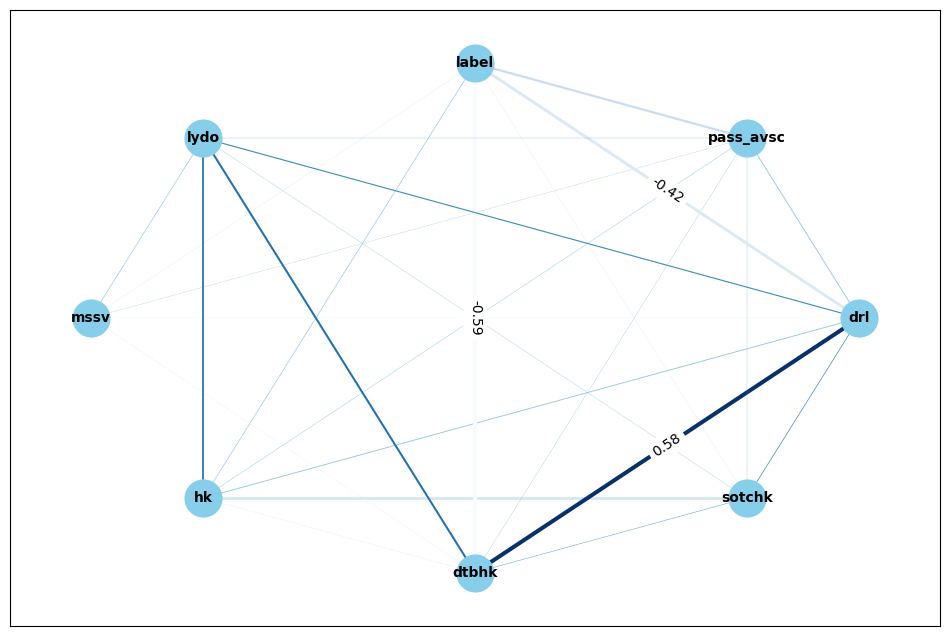

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

# Tính toán ma trận tương quan
corr = graph_data.corr()

# Khởi tạo đồ thị
G = nx.Graph()

# Ngưỡng cho hệ số tương quan
threshold = corr['label'].median()  # Sử dụng median của tương quan với 'label'

# Thêm cạnh dựa trên ngưỡng tương quan
for i in corr.columns:
    for j in corr.columns:
        if i != j and abs(corr.loc[i, j]) > threshold:
            G.add_edge(i, j, weight=corr.loc[i, j])

# Bố trí node
pos = nx.shell_layout(G)

# Vẽ đồ thị
plt.figure(figsize=(12, 8))

# Vẽ node
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue")
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

# Vẽ cạnh
edges = G.edges(data=True)
edge_colors = [d['weight'] for (_, _, d) in edges]
edge_widths = [abs(d['weight']) * 5 for (_, _, d) in edges]
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=plt.cm.Blues)

# Hiển thị nhãn cho cạnh có trọng số cao
high_weight_edges = {(i, j): f"{w['weight']:.2f}" for i, j, w in edges if abs(w['weight']) > 0.4}
nx.draw_networkx_edge_labels(G, pos, edge_labels=high_weight_edges)

# Hiển thị đồ thị
plt.show()

# Biến đổi ma trận

In [46]:
# Nhóm dữ liệu theo 'mssv' và 'hk', tính trung bình của 'dtbhk' và 'sotchk'
ultimate_merged_df_1 = ultimate_merged_df.groupby(['mssv', 'hk']).agg({'dtbhk': 'mean', 'sotchk': 'mean'})
ultimate_merged_df_1

dtbhk  sotchk
mssv                                     hk               
0001EB57XPvAibaEXe/twT+sf632fUXnsgPGeB4G 1   8.840    17.0
                                         2   9.000    21.0
                                         3   9.110    15.0
                                         4   8.750    19.0
                                         5   8.540    20.0
...                                            ...     ...
FFFA4234XPvAibaEXe+OhmjSj4XEzdTGgcTdT9fT 4   7.860    19.0
                                         5   7.655    11.0
                                         6   8.490    19.0
                                         7   7.250    18.0
                                         8   8.100    13.0

[63038 rows x 2 columns]

In [47]:
# Chuyển dữ liệu từ dạng nhóm thành dạng bảng chéo (pivot table) với 'mssv' làm chỉ mục, 'hk' làm cột và giá trị là 'dtbhk' và 'sotchk'
pivot_df_transcript = ultimate_merged_df_1.pivot_table(index='mssv', columns=['hk'], values=['dtbhk', 'sotchk'])
pivot_df_transcript

dtbhk                            \
hk                                          1     2      3     4      5    
mssv                                                                       
0001EB57XPvAibaEXe/twT+sf632fUXnsgPGeB4G  8.84  9.00  9.110  8.75  8.540   
00046394XPvAibaEXe+fmxcqgvribEcT4YmJhSFD  5.41  7.07  7.055  8.32  7.860   
000AD0D8XPvAibaEXe+RQyZpP6sq6qqIPZXybx3Q  8.85  8.64  8.410  8.05  7.460   
0013D6E5XPvAibaEXe85hkLGQAJy3XgK9pA18A31  8.31  8.14  7.010  7.87  8.040   
0018C59CXPvAibaEXe8C3lblh2dNniH+SYgLosUA  7.96  8.04  3.455  8.49  8.850   
...                                        ...   ...    ...   ...    ...   
FFDFD671XPvAibaEXe8/3iNqySORb8gPuwsQ8fwa  6.61  4.58  1.970  4.57  5.645   
FFE53E27XPvAibaEXe+boSxJoV2lkIPm7Byt5HdS  9.13  7.84  7.390  7.68  7.940   
FFE9E452XPvAibaEXe+6MN9FoW2mqXtx1lMTF9+D  8.25  8.10  8.380  8.21  7.500   
FFEF294AXPvAibaEXe/ceziXFRXnLc/x/K0hVw4d  4.64  6.76  7.555  7.28  8.045   
FFFA4234XPvAibaEXe+OhmjSj4XEzdTGgcTdT9fT  7.52  6.84  7.490  7.86  7.655   

                                                                      ...  \
hk                                          6      7     8    9   10  ...   
mssv                                                                  ...   
0001EB57XPvAibaEXe/twT+sf632fUXnsgPGeB4G  8.74  8.410   NaN  NaN NaN  ...   
00046394XPvAibaEXe+fmxcqgvribEcT4YmJhSFD  8.09  6.920  7.80  8.2 NaN  ...   
000AD0D8XPvAibaEXe+RQyZpP6sq6qqIPZXybx3Q  7.28  8.550  7.24  NaN NaN  ...   
0013D6E5XPvAibaEXe85hkLGQAJy3XgK9pA18A31  8.89  8.530   NaN  NaN NaN  ...   
0018C59CXPvAibaEXe8C3lblh2dNniH+SYgLosUA  7.40    NaN   NaN  NaN NaN  ...   
...                                        ...    ...   ...  ...  ..  ...   
FFDFD671XPvAibaEXe8/3iNqySORb8gPuwsQ8fwa  0.00  0.225   NaN  NaN NaN  ...   
FFE53E27XPvAibaEXe+boSxJoV2lkIPm7Byt5HdS  8.15  9.400   NaN  NaN NaN  ...   
FFE9E452XPvAibaEXe+6MN9FoW2mqXtx1lMTF9+D  8.16  7.970  7.94  NaN NaN  ...   
FFEF294AXPvAibaEXe/ceziXFRXnLc/x/K0hVw4d  7.26  7.880  7.10  8.7 NaN  ...   
FFFA4234XPvAibaEXe+OhmjSj4XEzdTGgcTdT9fT  8.49  7.250  8.10  NaN NaN  ...   

                                         sotchk                                \
hk                                           3     4     5     6     7     8    
mssv                                                                            
0001EB57XPvAibaEXe/twT+sf632fUXnsgPGeB4G   15.0  19.0  20.0  20.0   9.0   NaN   
00046394XPvAibaEXe+fmxcqgvribEcT4YmJhSFD   15.5  16.0  14.0  14.0  21.0  11.0   
000AD0D8XPvAibaEXe+RQyZpP6sq6qqIPZXybx3Q   15.0  20.0  20.0  19.0  15.0  10.0   
0013D6E5XPvAibaEXe85hkLGQAJy3XgK9pA18A31   23.0  22.0  22.0  15.0  12.0   NaN   
0018C59CXPvAibaEXe8C3lblh2dNniH+SYgLosUA    9.0  22.0  23.0  22.0   NaN   NaN   
...                                         ...   ...   ...   ...   ...   ...   
FFDFD671XPvAibaEXe8/3iNqySORb8gPuwsQ8fwa    9.5  14.0  10.0  14.0   7.0   NaN   
FFE53E27XPvAibaEXe+boSxJoV2lkIPm7Byt5HdS   21.0  19.0  20.0  15.0  10.0   NaN   
FFE9E452XPvAibaEXe+6MN9FoW2mqXtx1lMTF9+D   24.0  18.0  15.0  14.0  18.0  16.0   
FFEF294AXPvAibaEXe/ceziXFRXnLc/x/K0hVw4d   10.0  18.0  11.0  18.0  16.0   3.0   
FFFA4234XPvAibaEXe+OhmjSj4XEzdTGgcTdT9fT   21.0  19.0  11.0  19.0  18.0  13.0   

                                                            
hk                                          9   10  11  12  
mssv                                                        
0001EB57XPvAibaEXe/twT+sf632fUXnsgPGeB4G   NaN NaN NaN NaN  
00046394XPvAibaEXe+fmxcqgvribEcT4YmJhSFD  10.0 NaN NaN NaN  
000AD0D8XPvAibaEXe+RQyZpP6sq6qqIPZXybx3Q   NaN NaN NaN NaN  
0013D6E5XPvAibaEXe85hkLGQAJy3XgK9pA18A31   NaN NaN NaN NaN  
0018C59CXPvAibaEXe8C3lblh2dNniH+SYgLosUA   NaN NaN NaN NaN  
...                                        ...  ..  ..  ..  
FFDFD671XPvAibaEXe8/3iNqySORb8gPuwsQ8fwa   NaN NaN NaN NaN  
FFE53E27XPvAibaEXe+boSxJoV2lkIPm7Byt5HdS   NaN NaN NaN NaN  
FFE9E452XPvAibaEXe+6MN9FoW2mqXtx1lMTF9+D   NaN NaN NaN NaN  
FFEF294AXPvAibaEXe/ceziXFRXnLc

In [48]:
# Tạo danh sách các cột mới
new_columns = []
for column in pivot_df_transcript.columns:
  attrb, hocky = column
  if hocky > 12:
    pivot_df_transcript = pivot_df_transcript.drop(columns=column)
    continue
  # Tạo tên cột mới theo định dạng "HK{hocky}_{attrb}"
  new_column = f"HK{hocky}_{attrb}"
  new_columns.append(new_column)

pivot_df_transcript.columns = new_columns
pivot_df_transcript.reset_index(inplace=True)

pivot_df_transcript.head(5)

,mssv,HK1_dtbhk,HK2_dtbhk,HK3_dtbhk,HK4_dtbhk,HK5_dtbhk,HK6_dtbhk,HK7_dtbhk,HK8_dtbhk,HK9_dtbhk,...,HK3_sotchk,HK4_sotchk,HK5_sotchk,HK6_sotchk,HK7_sotchk,HK8_sotchk,HK9_sotchk,HK10_sotchk,HK11_sotchk,HK12_sotchk
0,0001EB57XPvAibaEXe/twT+sf632fUXnsgPGeB4G,8.84,9.00,9.110,8.75,8.54,8.74,8.41,NaN,NaN,...,15.0,19.0,20.0,20.0,9.0,NaN,NaN,NaN,NaN,NaN
1,00046394XPvAibaEXe+fmxcqgvribEcT4YmJhSFD,5.41,7.07,7.055,8.32,7.86,8.09,6.92,7.80,8.2,...,15.5,16.0,14.0,14.0,21.0,11.0,10.0,NaN,NaN,NaN
2,000AD0D8XPvAibaEXe+RQyZpP6sq6qqIPZXybx3Q,8.85,8.64,8.410,8.05,7.46,7.28,8.55,7.24,NaN,...,15.0,20.0,20.0,19.0,15.0,10.0,NaN,NaN,NaN,NaN
3,0013D6E5XPvAibaEXe85hkLGQAJy3XgK9pA18A31,8.31,8.14,7.010,7.87,8.04,8.89,8.53,NaN,NaN,...,23.0,22.0,22.0,15.0,12.0,NaN,NaN,NaN,NaN,NaN
4,0018C59CXPvAibaEXe8C3lblh2dNniH+SYgLosUA,7.96,8.04,3.455,8.49,8.85,7.40,NaN,NaN,NaN,...,9.0,22.0,23.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Tạo bảng pivot từ `ultimate_merged_df` với 'mssv' làm chỉ mục, 'hk' làm cột, và giá trị 'drl' làm giá trị của bảng
pivot_df_drl = ultimate_merged_df[['mssv','drl','hk']].pivot_table(index='mssv', columns='hk', values='drl', aggfunc='first')

new_columns=[]
for column in pivot_df_drl.columns:
    hocky = column
    if hocky > 12:
      pivot_df_drl = pivot_df_drl.drop(columns=column)
      continue
    # Tạo tên cột mới theo định dạng "HK{hocky}_drl"
    new_column = f"HK{hocky}_drl"
    new_columns.append(new_column)

pivot_df_drl.columns= new_columns
pivot_df_drl.reset_index(inplace=True)
pivot_df_drl.head(5)

,mssv,HK1_drl,HK2_drl,HK3_drl,HK4_drl,HK5_drl,HK6_drl,HK7_drl,HK8_drl,HK9_drl,HK10_drl,HK11_drl,HK12_drl
0,0001EB57XPvAibaEXe/twT+sf632fUXnsgPGeB4G,100.0,100.0,100.0,100.0,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN
1,00046394XPvAibaEXe+fmxcqgvribEcT4YmJhSFD,81.0,76.0,75.0,91.0,77.0,71.0,64.0,70.0,76.0,NaN,NaN,NaN
2,000AD0D8XPvAibaEXe+RQyZpP6sq6qqIPZXybx3Q,85.0,100.0,96.0,100.0,100.0,90.0,86.0,84.0,NaN,NaN,NaN,NaN
3,0013D6E5XPvAibaEXe85hkLGQAJy3XgK9pA18A31,90.0,95.0,100.0,79.0,88.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN
4,0018C59CXPvAibaEXe8C3lblh2dNniH+SYgLosUA,95.0,95.0,100.0,95.0,100.0,97.0,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra cho các lớp 'BTH' và 'totnghiep' với tỷ lệ 70% cho tập huấn luyện
train_pos, test_pos = train_test_split(df_BTH[['mssv','label']], train_size=0.7, random_state=18)
train_neg, test_neg = train_test_split(df_totnghiep[['mssv','label']], train_size=0.7, random_state= 18)

# Kết hợp các tập huấn luyện và kiểm tra thành tập huấn luyện và kiểm tra cuối cùng
train_set = pd.concat([train_pos, train_neg])
test_set = pd.concat([test_pos, test_neg])

# Kết hợp dữ liệu từ pivot_df_drl và pivot_df_transcript
data = pivot_df_drl.merge(pivot_df_transcript, on='mssv', how='right')

# Kết hợp với dữ liệu từ df_xeploaiav để thêm cột 'pass_avsc'
data = data.merge(df_xeploaiav[['mssv','pass_avsc']], how='left', on='mssv')

In [51]:
# Kết hợp dữ liệu từ tập huấn luyện và kiểm tra để tạo thành dataset hoàn chỉnh
dataset= pd.concat([train_set,test_set])

# Vẽ biểu đồ tròn để thống kê số lượng quan sát ở mỗi lớp
fig = go.Figure(data=[go.Pie(labels=dataset['label'].value_counts().index, values=dataset['label'].value_counts().values, textinfo='value+percent', hole=0.5)])
fig.update_layout(go.Layout(title='Thống kê số lượng quan sát ở mỗi class'))
fig.update_layout(width=800, height=600)
fig.show()

In [52]:
def generate_data(input_set, backward=1):
    # Merge input_set với các DataFrame khác
    df_warning_subset = input_set.merge(df_warning, on='mssv')
    output_data = input_set.merge(data, on='mssv')

    # Kiểm tra giá trị backward và áp dụng các thao tác trên dữ liệu
    if backward > 0:
        for i in range(backward):
            checkpoint = pd.DataFrame(df_transcript.groupby('mssv')['hk'].max()) - i
            checkpoint.reset_index(inplace=True)
            # Đảm bảo học kỳ (hk) không quá giới hạn (1-12)
            checkpoint.loc[checkpoint['hk'] > 12, 'hk'] = 12
            checkpoint.loc[checkpoint['hk'] < 1, 'hk'] = 1

            # Cập nhật giá trị trong output_data theo các checkpoint
            for mssv, hk in checkpoint.itertuples(index=False):
                col_name = [f'HK{hk}_drl', f'HK{hk}_sotchk', f'HK{hk}_dtbhk']
                output_data.loc[output_data['mssv'] == mssv, col_name] = np.nan

            # Xóa hàng có quá nhiều giá trị NaN trong output_data
            dtb_columns = [col for col in output_data.columns if col.endswith('_dtbhk')]
            nan_counts = output_data[dtb_columns].isna().sum(axis=1)
            drop_mask = nan_counts > 10
            output_data = output_data.drop(output_data[drop_mask].index)

            # Xóa các cảnh báo không cần thiết trong df_warning_subset
            for mssv, hk in checkpoint.itertuples(index=False):
                df_warning_subset.drop(
                    df_warning_subset[(df_warning_subset['mssv'] == mssv) &
                                      (df_warning_subset['hk'] == hk)].index, inplace=True)

    # Tạo pivot_df_warning_subset để tái cấu trúc dữ liệu cảnh báo
    pivot_df_warning_subset = df_warning_subset[['mssv', 'lanthu', 'lydo']].pivot_table(
        index='mssv', columns='lanthu', values='lydo', aggfunc='first'
    )

    # Đảm bảo pivot_df_warning_subset có cột tối thiểu là 6
    while len(pivot_df_warning_subset.columns) < 6:
        pivot_df_warning_subset[max(pivot_df_warning_subset.columns) + 1] = np.nan

    # Đổi tên cột của pivot_df_warning_subset
    new_columns = [f"CCHV_{lanthu}" for lanthu in pivot_df_warning_subset.columns]
    pivot_df_warning_subset.columns = new_columns
    pivot_df_warning_subset.reset_index(inplace=True)

    # Trả về DataFrame hợp nhất
    return output_data.merge(pivot_df_warning_subset, on='mssv', how='left').drop('mssv', axis=1)


In [53]:
# Áp dụng hàm generate_data cho tập huấn luyện và tập kiểm tra với backward = 1 và xáo trộn các dữ liệu
train_data = generate_data(train_set, backward=1).sample(frac = 1)
test_data = generate_data(test_set, backward=1).sample(frac = 1)

In [54]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1884 entries, 880 to 471
Data columns (total 44 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   label        1884 non-null   int64  
 1   HK1_drl      1884 non-null   float64
 2   HK2_drl      1879 non-null   float64
 3   HK3_drl      1801 non-null   float64
 4   HK4_drl      1741 non-null   float64
 5   HK5_drl      1680 non-null   float64
 6   HK6_drl      1601 non-null   float64
 7   HK7_drl      1518 non-null   float64
 8   HK8_drl      1041 non-null   float64
 9   HK9_drl      283 non-null    float64
 10  HK10_drl     123 non-null    float64
 11  HK11_drl     56 non-null     float64
 12  HK12_drl     0 non-null      float64
 13  HK1_dtbhk    1884 non-null   float64
 14  HK2_dtbhk    1879 non-null   float64
 15  HK3_dtbhk    1801 non-null   float64
 16  HK4_dtbhk    1741 non-null   float64
 17  HK5_dtbhk    1680 non-null   float64
 18  HK6_dtbhk    1601 non-null   float64
 19  HK7_dtbhk 

In [55]:
# Export dataset
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)